In [1]:
from keras.applications import VGG16

In [2]:
vgg16 = VGG16(include_top=False,
              weights='imagenet',
              input_shape = (224,224,3))

58892288/58889256 [==============================] - 0s 0us/step


In [3]:
for layer in vgg16.layers:
  layer.trainable = False

In [4]:
for i, layer in enumerate(vgg16.layers):
  print(str(i) + " " + layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [5]:
def addTopModelVGG16(bottom_model , num_classes = 2):
  top_model = bottom_model.output
  top_model = Flatten()(top_model)
  top_model = Dense(units = 256, activation = 'relu')(top_model)
  top_model = Dense(units = 256, activation = 'relu')(top_model)
  top_model = Dropout(rate = 0.2)(top_model)
  top_model = Dense(units = 256, activation = 'relu')(top_model)
  top_model = Dense(units = num_classes , activation = "softmax")(top_model)
  return top_model

In [6]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPool2D, BatchNormalization,ZeroPadding2D

FC_Head = addTopModelVGG16(vgg16)

model = Model(inputs = vgg16.input, outputs= FC_Head)

In [7]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint , EarlyStopping

model.compile(optimizer=Adam(), loss = 'categorical_crossentropy', metrics= ['accuracy'])

In [9]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/drive/My Drive/dataset/training_set/'
validation_data_dir = '/content/drive/My Drive/dataset/test_set/'

img_rows , img_cols = 224, 224

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 16
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [11]:
checkpoint = ModelCheckpoint('vgg16_cat_vs_dog.h5',
                             monitor = 'val_loss',
                             mode = 'min',
                             save_best_only = True)
earlystopping = EarlyStopping(monitor='val_loss',
                              mode = 'min',
                              min_delta = 0,
                              patience = 3,
                              restore_best_weights = True)

In [12]:
callbacks = [checkpoint, earlystopping]

model.fit(train_generator,
          steps_per_epoch = 8000//32,
          epochs = 5,
          batch_size = 32,
          callbacks = callbacks,
          validation_data = validation_generator,
          validation_steps = 2000//32)

Epoch 1/5
250/250 [==============================] - 1172s 5s/step - loss: 0.7501 - accuracy: 0.6882 - val_loss: 0.6732 - val_accuracy: 0.6613
Epoch 2/5
250/250 [==============================] - 514s 2s/step - loss: 0.3244 - accuracy: 0.8640 - val_loss: 0.3856 - val_accuracy: 0.8081
Epoch 3/5
250/250 [==============================] - 278s 1s/step - loss: 0.2999 - accuracy: 0.8713 - val_loss: 0.1665 - val_accuracy: 0.9500
Epoch 4/5
250/250 [==============================] - 169s 676ms/step - loss: 0.2786 - accuracy: 0.8764 - val_loss: 0.3002 - val_accuracy: 0.8629
Epoch 5/5
250/250 [==============================] - 121s 485ms/step - loss: 0.2482 - accuracy: 0.8947 - val_loss: 0.1302 - val_accuracy: 0.9742


In [13]:
from keras.models import load_model
classifier = load_model('vgg16_cat_vs_dog.h5')

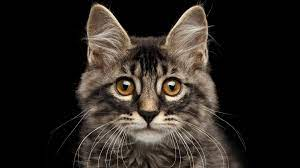

Cat


In [24]:
from keras.preprocessing import image
import numpy as np
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread('download.jpg')
cv2_imshow(img)

test_image = image.load_img('download.jpg', target_size = (224,224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = classifier.predict(test_image)
result = np.argmax(result)
#print(result)
#train_generator.class_indices
if result == 0:
  print("Cat")
else:
  print("Dog")

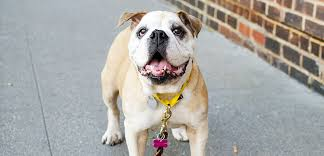

Dog


In [26]:
img = cv2.imread('images.jpg')
cv2_imshow(img)

test_image = image.load_img('images.jpg', target_size = (224,224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = classifier.predict(test_image)
result = np.argmax(result)
#print(result)
#train_generator.class_indices
if result == 0:
  print("Cat")
else:
  print("Dog")